# Principle of Data Science - Coursework
### Sin Sze Li 210035720

## Part 1: Data preparation


In [1]:
# Import libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import os, glob

### 1.1 Players overview dataset

The information of players can be found in two csv files

- 'atp_players' (player_id same as those in match dataset and ranks dataset)
- 'player_overviews_unindexed' (backhand style of players)

In [2]:
# Load the dataframe
players = pd.read_csv('atp_players.csv')
style = pd.read_csv('player_overviews_unindexed.csv')

# Merge two dataframes based on player names
players = pd.merge(left=players, right=style, how='outer', left_on=['name_first','name_last'], right_on=['first_name', 'last_name'])
players.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 59776 entries, 0 to 59775
Data columns (total 28 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   player_id_x    55393 non-null  float64
 1   name_first     55216 non-null  object 
 2   name_last      55351 non-null  object 
 3   hand           55150 non-null  object 
 4   dob            44447 non-null  object 
 5   ioc            55338 non-null  object 
 6   height         2469 non-null   float64
 7   wikidata_id    4900 non-null   object 
 8   player_id_y    11187 non-null  object 
 9   player_slug    11187 non-null  object 
 10  first_name     11187 non-null  object 
 11  last_name      11187 non-null  object 
 12  player_url     11187 non-null  object 
 13  flag_code      8997 non-null   object 
 14  residence      2029 non-null   object 
 15  birthplace     3087 non-null   object 
 16  birthdate      5197 non-null   object 
 17  birth_year     5197 non-null   float64
 18  birth_

In [3]:
# Delete repeated and unrelated columns
players = players.drop(['dob', 'ioc', 'wikidata_id', 'player_id_y', 'player_slug', 'first_name',
                        'last_name', 'player_url', 'flag_code', 'residence', 'birthplace', 
                        'birthdate', 'birth_year','birth_month', 'birth_day', 'turned_pro',
                        'weight_lbs','weight_kg','height_ft', 'height_inches', 'handedness'],
                         axis=1)

# Rename 'player_id_x' as 'player_id'
players = players.rename(columns={'player_id_x':'player_id'})

# Check for missing values
players.isna().sum()

player_id      4383
name_first     4560
name_last      4425
hand           4626
height        57307
height_cm     57088
backhand      58638
dtype: int64

Since 'backhand' is one of the factors under investigation, and 'player_id' helps us map the player to the match data, rows contain missing values in these columns are deleted.


In [4]:
# Delete rows with missing values in 'player_id' and 'backhand'
players = players.dropna(subset=['player_id', 'backhand'])

Also, find out the possible values of players handedness. 

In [5]:
players.hand.unique()

array(['R', 'L', 'U'], dtype=object)

Looking up in the description of dataset, U represents unknown handedness and also ambidextrous players. Since we are only interested in left-handed and right-handed players, delete rows with handedness 'U'.

In [6]:
players = players.drop(players[players.hand =='U'].index)

Both 'height' and 'height_cm' contains the height of players and some missing values. A new column, 'height_final' is created to contain:
- value in 'height', if both 'height' and 'height_cm' contain the same value
- value in 'height', if 'height_cm' contains missing value
- value in 'height_cm', if 'height' contains missing value

If both 'height' and 'height_cm' contain missing values, drop that row.


In [7]:
players['height_final'] = 0

# Index for column 'height'
idx_height = players.columns.get_loc('height')

# Index for column 'height_cm'
idx_height_cm = players.columns.get_loc('height_cm')

# Index for column 'height_final'
idx_height_final = players.columns.get_loc('height_final')

# List to store row index to drop
todrop = []

for i in range(len(players)):
    if players.iloc[i, idx_height] == players.iloc[i, idx_height_cm]:
        players.iloc[i, idx_height_final] = players.iloc[i, idx_height]
    elif (players.isna().iloc[i, idx_height] == True) and (players.isna().iloc[i, idx_height_cm] == False):
        players.iloc[i, idx_height_final] = players.iloc[i, idx_height_cm]
    elif (players.isna().iloc[i, idx_height_cm] == True) and (players.isna().iloc[i, idx_height] == False):
        players.iloc[i, idx_height_final] = players.iloc[i, idx_height]
    else:
        todrop.append(i)
        
players = players.drop(players.index[todrop])

# Delete 'height' and 'height_cm'
players = players.drop(['height', 'height_cm'], axis=1)

/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


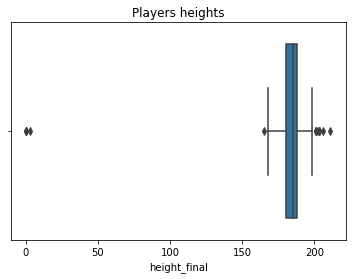

In [8]:
# Distribution of height_final
plt.figure()
plt.title('Players heights')
sns.boxplot(players['height_final'])

# A player's height cannot be less that 50 cm. Those are outliers.
# Delete outliers
players = players.drop(players[players.height_final < 150].index)

In [9]:
players.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 673 entries, 79 to 52336
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   player_id     673 non-null    float64
 1   name_first    673 non-null    object 
 2   name_last     673 non-null    object 
 3   hand          673 non-null    object 
 4   backhand      673 non-null    object 
 5   height_final  673 non-null    int64  
dtypes: float64(1), int64(1), object(4)
memory usage: 36.8+ KB


### 1.2 Rank dataset

#### 1.2.1 Combine rank data files from 2010 to 2021
Since the ranking data are scattered in 3 different files, they are merged to a single CSV file for the analysis.

(Commented out to avoid saving multiple files)

In [10]:
# #Set the working directory
# path2 = "/Users/ceciliali/Documents/MSc Data Science/Principles of Data Science/coursework/atp_rank"

# #Match CSV files by pattern
# all_rank_files = glob.glob(os.path.join(path2, "atp_*.csv"))

# #Combine all file and export as single CSV file 'rank_data.csv'
# df_from_each_rank_file = (pd.read_csv(f, sep=',') for f in all_rank_files)
# df_rank_data = pd.concat(df_from_each_rank_file, ignore_index=True)
# df_rank_data.to_csv('rank_data.csv')

#### 1.2.2 Data cleaning

In [11]:
# Load the dataframe
rank = pd.read_csv('rank_data.csv')
rank.info()

# Rename the column 'player' to 'player_id'
rank = rank.rename(columns={'player':'player_id'})

# Check for duplicated rows with same value of 'ranking_date' and 'player'
s = rank.duplicated(['ranking_date', 'player_id'])
print(s.value_counts())

# Delete duplicated rows with same value of 'ranking_date' and 'player'
rank = rank.drop_duplicates(['ranking_date', 'player_id'])

# Check for missin values
rank.isna().sum()

# Delete rows with missing values
rank = rank.dropna()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 997095 entries, 0 to 997094
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Unnamed: 0    997095 non-null  int64  
 1   ranking_date  997095 non-null  int64  
 2   rank          997095 non-null  int64  
 3   player        997095 non-null  int64  
 4   points        996862 non-null  float64
dtypes: float64(1), int64(4)
memory usage: 38.0 MB
False    996794
True        301
dtype: int64


In [12]:
rank.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 996561 entries, 0 to 997094
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Unnamed: 0    996561 non-null  int64  
 1   ranking_date  996561 non-null  int64  
 2   rank          996561 non-null  int64  
 3   player_id     996561 non-null  int64  
 4   points        996561 non-null  float64
dtypes: float64(1), int64(4)
memory usage: 45.6 MB


### 1.3 Match dataset

#### 1.3.1 Combine match data files from 2010 to 2020
Since the match data are scattered in several files, they are merged to a single CSV file for the analysis.

(Commented out to avoid saving multiple files)

In [13]:
# # Show all columns in the dataframes
# pd.set_option('display.max_columns', None)
# pd.set_option('display.max_rows', 15)

In [14]:
# # Code adapted and modified from https://blog.softhints.com/how-to-merge-multiple-csv-files-with-python/
# # Set the working directory
# path1 = '/Users/ceciliali/Documents/MSc Data Science/Principles of Data Science/coursework/atp_matches'

# # Match CSV files by pattern
# all_files = glob.glob(os.path.join(path1, 'atp_*.csv'))

# # Combine all file and export as single CSV file named 'match_data'
# df_from_each_file = (pd.read_csv(f, sep=',') for f in all_files)
# df_match_data = pd.concat(df_from_each_file, ignore_index=True)
# df_match_data.to_csv('match_data.csv')

In [15]:
# Load the data
match = pd.read_csv('match_data.csv')

#### 1.1.2 Missing values

In [16]:
# Find missing values
match.isna().sum()

Unnamed: 0                0
tourney_id                0
tourney_name              0
surface                 198
draw_size                 0
tourney_level             0
tourney_date              0
match_num                 0
winner_id                 0
winner_seed           17597
winner_entry          27049
winner_name               0
winner_hand               7
winner_ht              1348
winner_ioc                0
winner_age                6
loser_id                  0
loser_seed            23515
loser_entry           24604
loser_name                0
loser_hand               41
loser_ht               2784
loser_ioc                 0
loser_age                 2
score                     0
best_of                   0
round                     0
minutes                3522
w_ace                  2214
w_df                   2214
w_svpt                 2214
w_1stIn                2214
w_1stWon               2214
w_2ndWon               2214
w_SvGms                2214
w_bpSaved           

Surface of the court, player's handedness, player's height and their ranks are factors under investigation. Their missing values cannot be replaced with 0. Since there are only a few missing values compared to the total number of record, rows with missing values are deleted.

In [17]:
# Delete rows with missing values in 'surface', 'winner_hand', 'loser_hand', 'winner_ht', 'loser_ht', 'winner_rank', 'loser_rank'
match = match.dropna(subset=['surface', 'winner_hand', 'loser_hand', 'winner_ht', 'loser_ht', 'winner_rank', 'loser_rank'])

The seed numbers are only allocated to players with higher ranks so most players do not have it. There are 32 seeds in Grand Slam tournaments, so replace the missing values to 33 to represent players with no seed numbers.

In [18]:
# Print unique values in 'winner_seed' and 'lower_seed'
print(match['winner_seed'].unique())
print(match['loser_seed'].unique())

# Replace missing value with '0' in 'winner_seed' and 'loser_seed'
match[['winner_seed','loser_seed']] = match[['winner_seed','loser_seed']].fillna(33)

[ 2.  4. nan  7.  5.  6.  8.  1.  3. 14. 16. 22. 28. 23. 15. 19. 26. 27.
 32. 10. 11. 12. 18. 20. 21. 24. 25. 30.  9. 13. 17. 29. 31. 33.]
[ 4. nan  7.  5.  6.  8.  3.  1.  2.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 30. 31. 32. 29. 33.]


The entry method of players is related to the players' ranks and seed numbers. Since players' ranks and seed numbers are available, players' entry can be deleted considering the number of missing values.

In [19]:
# Delete 'winner_entry' and 'loser_entry' columns
match = match.drop(['winner_entry', 'loser_entry'], axis=1)

The remaining data with missing values contributes to only about 5% of the total data. These rows are therefore deleted.

In [20]:
# Delete rows with missing values
match = match.dropna()

# Check missing values in the dataframe
match.isna().sum()

Unnamed: 0            0
tourney_id            0
tourney_name          0
surface               0
draw_size             0
tourney_level         0
tourney_date          0
match_num             0
winner_id             0
winner_seed           0
winner_name           0
winner_hand           0
winner_ht             0
winner_ioc            0
winner_age            0
loser_id              0
loser_seed            0
loser_name            0
loser_hand            0
loser_ht              0
loser_ioc             0
loser_age             0
score                 0
best_of               0
round                 0
minutes               0
w_ace                 0
w_df                  0
w_svpt                0
w_1stIn               0
w_1stWon              0
w_2ndWon              0
w_SvGms               0
w_bpSaved             0
w_bpFaced             0
l_ace                 0
l_df                  0
l_svpt                0
l_1stIn               0
l_1stWon              0
l_2ndWon              0
l_SvGms         

In [21]:
match.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 24851 entries, 0 to 30797
Data columns (total 48 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Unnamed: 0          24851 non-null  int64  
 1   tourney_id          24851 non-null  object 
 2   tourney_name        24851 non-null  object 
 3   surface             24851 non-null  object 
 4   draw_size           24851 non-null  int64  
 5   tourney_level       24851 non-null  object 
 6   tourney_date        24851 non-null  int64  
 7   match_num           24851 non-null  int64  
 8   winner_id           24851 non-null  int64  
 9   winner_seed         24851 non-null  float64
 10  winner_name         24851 non-null  object 
 11  winner_hand         24851 non-null  object 
 12  winner_ht           24851 non-null  float64
 13  winner_ioc          24851 non-null  object 
 14  winner_age          24851 non-null  float64
 15  loser_id            24851 non-null  int64  
 16  lose

#### 1.1.3 Outliers

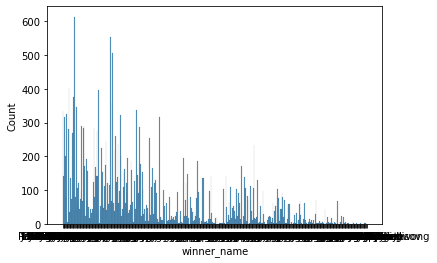

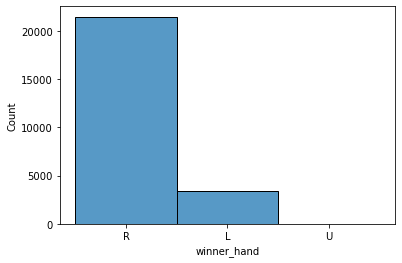

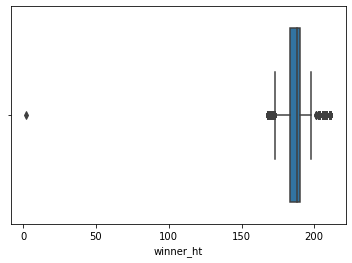

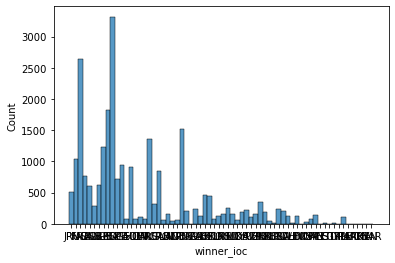

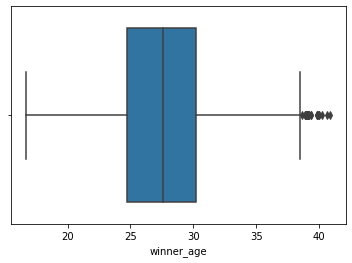

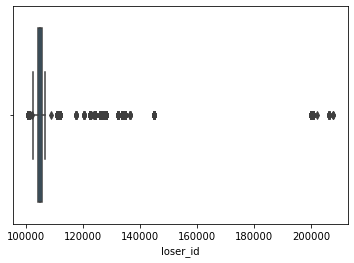

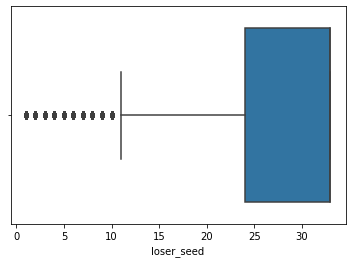

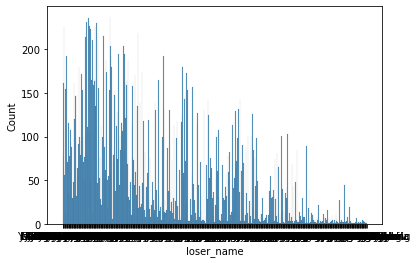

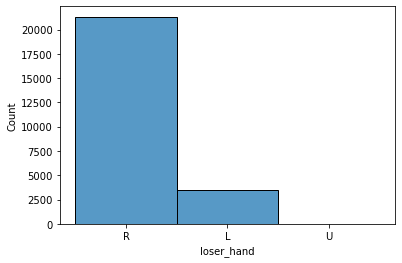

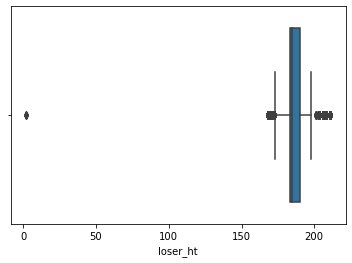

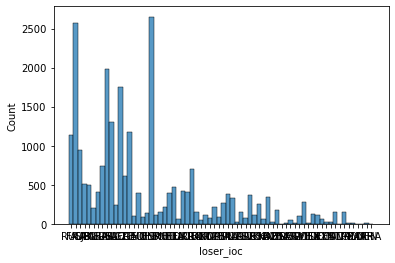

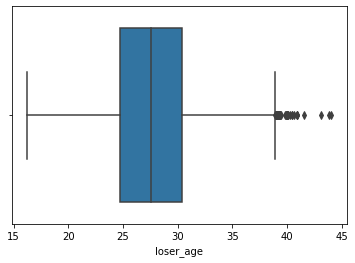

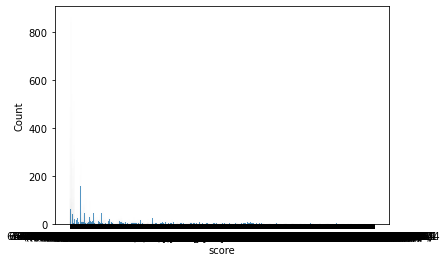

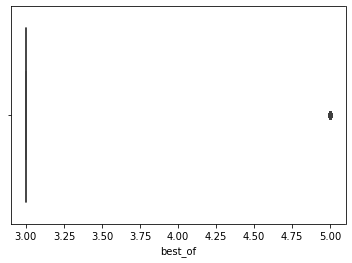

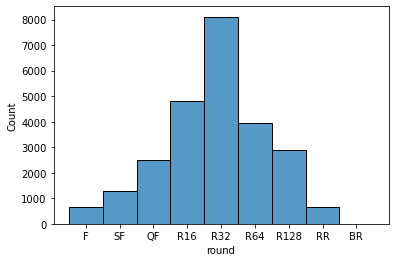

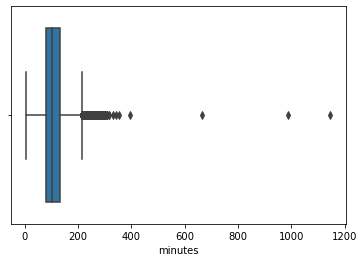

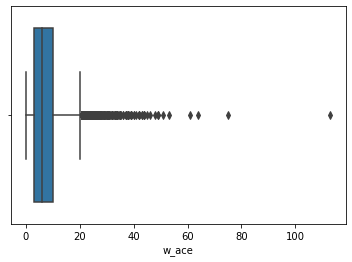

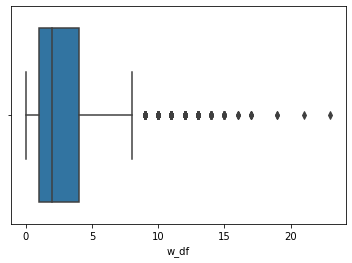

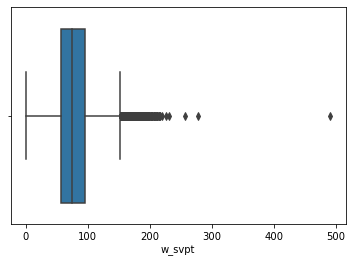

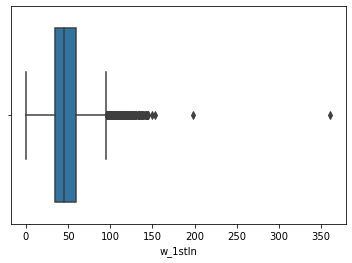

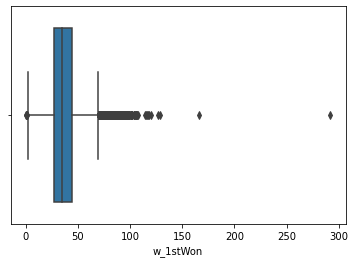

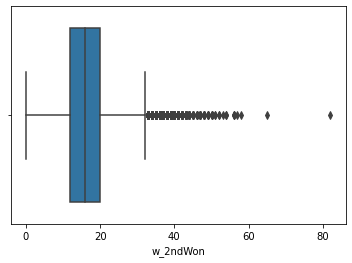

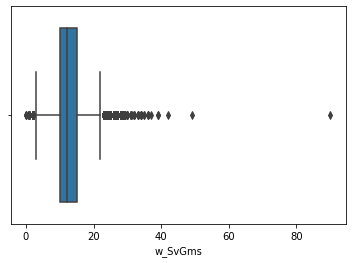

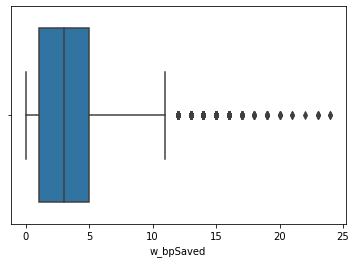

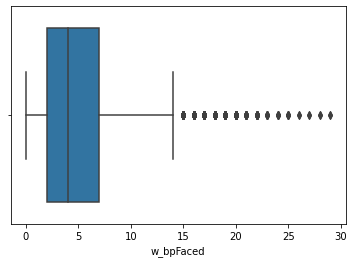

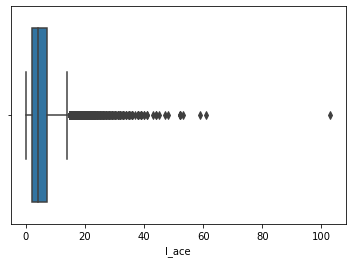

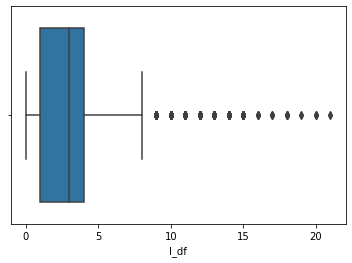

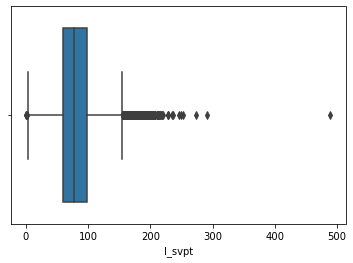

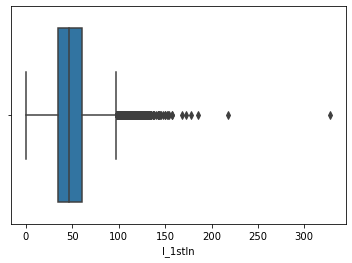

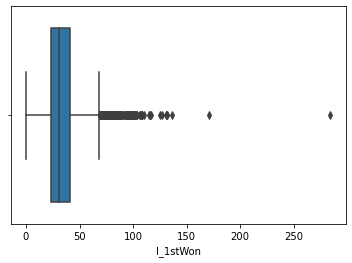

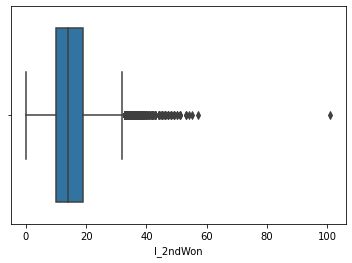

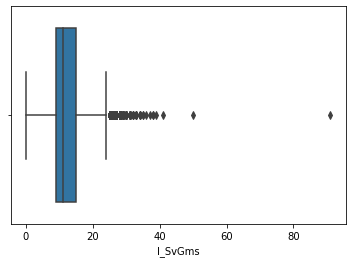

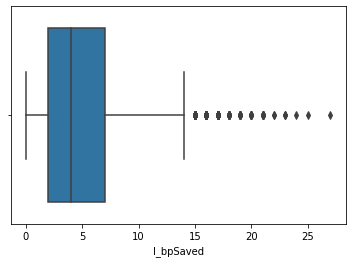

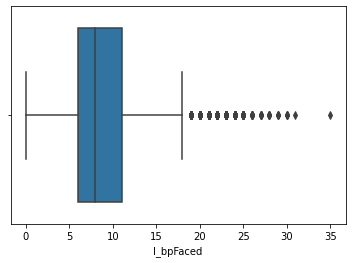

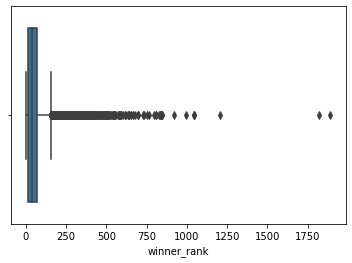

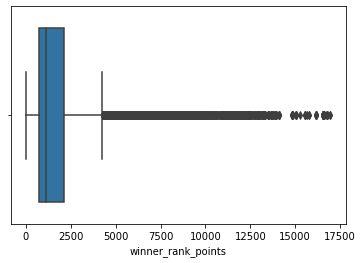

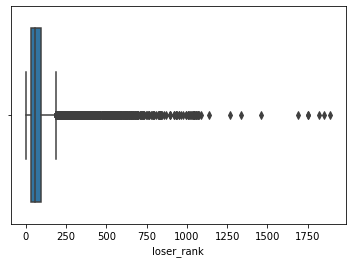

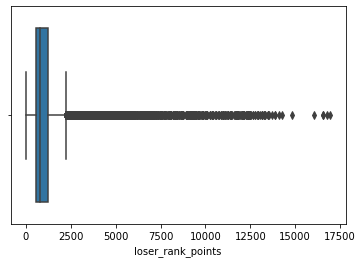

In [22]:
# Plot a boxplot for each column
for column in match.iloc[:,10:]:
    try:
        sns.boxplot(x=match[column])
        plt.show()
    except TypeError:
        sns.histplot(x=match[column])
        plt.show()

From the boxplot of 'minutes', it is shown that some matches lasted extremely long. These matches contribute to the outliers in other columns. 

Define outliers as matches with duration longer than twice the standard deviation from the mean, and delete from the dataframe.

In [23]:
# Create new column
match['isOutlierMinutes'] = 0

# Calculate the mean and standard deviation of duration of match
meanMinutes = match['minutes'].mean()
stdMinutes = match['minutes'].std()

# Assign 1 and 0 for outliers and non-outliers
match['isOutlierMinutes'] = np.where(abs(match['minutes']-meanMinutes) > 2*stdMinutes, 1, 0)

# Count the number of non-outliers and outliers
from collections import Counter
print(Counter(match['isOutlierMinutes']))

# Delete records that are outliers
match = match.drop(match[match['isOutlierMinutes'] == 1].index)

Counter({0: 23730, 1: 1121})


In [24]:
# Delete player height which is lower than 50 cm
match = match.drop(match[match.winner_ht < 50].index)
match = match.drop(match[match.loser_ht < 50].index)

In [25]:
# Reset dataframe index
match = match.reset_index()

match.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23726 entries, 0 to 23725
Data columns (total 50 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   index               23726 non-null  int64  
 1   Unnamed: 0          23726 non-null  int64  
 2   tourney_id          23726 non-null  object 
 3   tourney_name        23726 non-null  object 
 4   surface             23726 non-null  object 
 5   draw_size           23726 non-null  int64  
 6   tourney_level       23726 non-null  object 
 7   tourney_date        23726 non-null  int64  
 8   match_num           23726 non-null  int64  
 9   winner_id           23726 non-null  int64  
 10  winner_seed         23726 non-null  float64
 11  winner_name         23726 non-null  object 
 12  winner_hand         23726 non-null  object 
 13  winner_ht           23726 non-null  float64
 14  winner_ioc          23726 non-null  object 
 15  winner_age          23726 non-null  float64
 16  lose

## Part 2: Data Analysis

### 2.1 Players handedness

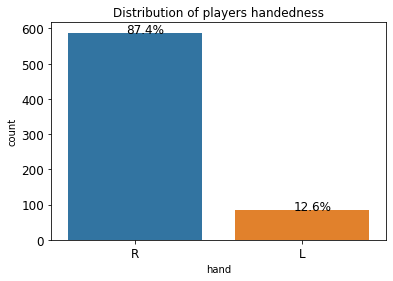

In [26]:
# Code adopted from https://stackoverflow.com/questions/31749448/how-to-add-percentages-on-top-of-bars-in-seaborn
# Bar chart to show the distribution of players handedness
def without_hue(plot, feature):
    total = len(feature)
    for p in plot.patches:
        percentage = '{:.1f}%'.format(100 * p.get_height()/total)
        x = p.get_x() + p.get_width() / 2 - 0.05
        y = p.get_y() + p.get_height()
        ax.annotate(percentage, (x, y), size = 12)
    plt.show()

ax = sns.countplot(data=players, x='hand')
plt.xticks(size=12)
plt.yticks(size=12)
plt.title('Distribution of players handedness')
without_hue(ax, players.hand)

### 2.2 Players backhand style

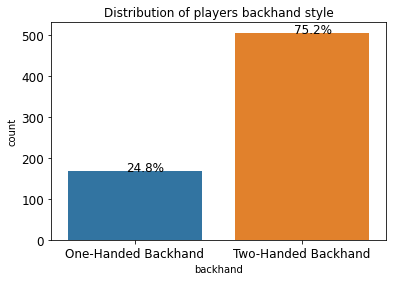

In [27]:
# Code adopted from https://stackoverflow.com/questions/31749448/how-to-add-percentages-on-top-of-bars-in-seaborn
# Bar chart to show the distribution of players backhand style
def without_hue(plot, feature):
    total = len(feature)
    for p in plot.patches:
        percentage = '{:.1f}%'.format(100 * p.get_height()/total)
        x = p.get_x() + p.get_width() / 2 - 0.05
        y = p.get_y() + p.get_height()
        ax.annotate(percentage, (x, y), size = 12)
    plt.show()

ax = sns.countplot(data=players, x='backhand')
plt.xticks(size=12)
plt.yticks(size=12)
plt.title('Distribution of players backhand style')
without_hue(ax, players.backhand)

### 2.3 Players rank according to players handedness and backhand style

To get an idea of how the right-handed and left-handed players, and players who play one-handed and two-handed backhand perform over the years, calculate the mean of ranks for each type of players on each ranking date, and plot a line graph to illustrate the change in ranks.

In [28]:
# Add the handedness and backhand style of each player as a new column
rank1 = rank.copy()
rank1 = rank1.merge(players[['player_id', 'hand', 'backhand']], on='player_id')

In [29]:
# Change the date format for ranking_date
rank1['ranking_date'] = pd.to_datetime(rank1['ranking_date'], format='%Y%m%d')

# Calculate the mean of rank for each type of player in yearly periods
rank1 = rank1.groupby([rank1['ranking_date'].dt.year, 'hand', 'backhand']).agg('mean')

# Reset index to make 
rank1 = rank1.reset_index()
rank1

,ranking_date,hand,backhand,Unnamed: 0,rank,player_id,points
0,2010,L,One-Handed Backhand,45651.521401,467.367704,104297.964981,249.276265
1,2010,L,Two-Handed Backhand,46249.945161,571.926728,105019.628571,462.822581
2,2010,R,One-Handed Backhand,46152.253883,440.443486,104446.364970,467.062554
3,2010,R,Two-Handed Backhand,46980.416545,514.050915,104956.373725,380.334062
4,2011,L,One-Handed Backhand,134906.451163,425.255814,104148.804651,219.209302
5,2011,L,Two-Handed Backhand,135213.045010,531.228963,105121.559687,498.105675
6,2011,R,One-Handed Backhand,133804.900098,487.018164,104638.099902,411.643348
7,2011,R,Two-Handed Backhand,134876.471573,528.749047,105171.392591,363.869551
8,2012,L,One-Handed Backhand,221214.640909,515.834091,104263.372727,186.079545
9,2012,L,Two-Handed Backhand,224029.124189,528.440502,105514.045868,392.198615


<AxesSubplot:title={'center':'Average players ranks based on handedness'}, xlabel='ranking_date', ylabel='rank'>

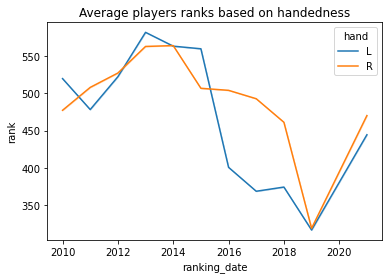

In [30]:
# Lineplot to show the change in average rank based on players handedness
plt.figure()
plt.title('Average players ranks based on handedness')
sns.lineplot(data=rank1, x='ranking_date', y='rank', hue='hand', ci=False)

<AxesSubplot:title={'center':'Average players rank based on backhand style'}, xlabel='ranking_date', ylabel='rank'>

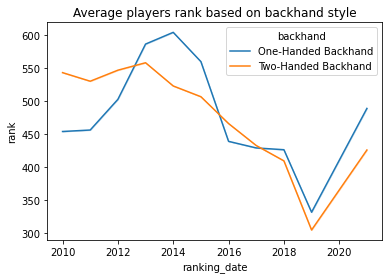

In [31]:
# Lineplot to show the change in average rank based on players backhand style
plt.figure()
plt.title('Average players rank based on backhand style')
sns.lineplot(data=rank1, x='ranking_date', y='rank', hue='backhand', ci=False)

The average rank of player increases in year 2018. This may be because the dataframe does not contain rank data for lower-ranked players in 2019. Count the number of row for each ranking date.

In [32]:
num_rank = []
for i in rank['ranking_date'].unique():
    num_rank.append(i)
    num_rank.append(rank.loc[rank['ranking_date'] == i].count())
print(num_rank)

[20100104, Unnamed: 0      1812
ranking_date    1812
rank            1812
player_id       1812
points          1812
dtype: int64, 20100111, Unnamed: 0      1814
ranking_date    1814
rank            1814
player_id       1814
points          1814
dtype: int64, 20100118, Unnamed: 0      1813
ranking_date    1813
rank            1813
player_id       1813
points          1813
dtype: int64, 20100125, Unnamed: 0      1813
ranking_date    1813
rank            1813
player_id       1813
points          1813
dtype: int64, 20100201, Unnamed: 0      1810
ranking_date    1810
rank            1810
player_id       1810
points          1810
dtype: int64, 20100208, Unnamed: 0      1741
ranking_date    1741
rank            1741
player_id       1741
points          1741
dtype: int64, 20100215, Unnamed: 0      1800
ranking_date    1800
rank            1800
player_id       1800
points          1800
dtype: int64, 20100222, Unnamed: 0      1795
ranking_date    1795
rank            1795
player_id       1795
po

In general, there should be abour 2000 players per ranking date. From the end of 2018 to July 2019, this number suddenly drops to about 680. After checking the ATP official website, it is confirmed that the ranks after 680 are missing in that period. 

Nontheless, it can be seen from the plot that from 2013 to 2018, the mean rank of left-handed players became significantly higher than that of right-handed players. 

To see the bigger picture, the mean and standard deviation of players ranks over the 10 years are calculated.

In [33]:
# Make a copy of rank dataframe, and add the hand and backhand column to it
rank2 = rank.copy()
rank2 = rank2.merge(players[['player_id', 'hand', 'backhand']], on='player_id')

In [34]:
# Compute the mean of ranks
print('Mean: Right-handed', rank2[rank2.hand == 'R']['rank'].mean())
print('Mean: Left-handed', rank2[rank2.hand == 'L']['rank'].mean())
print('Mean: One-Handed Backhand', rank2[rank2.backhand == 'One-Handed Backhand']['rank'].mean())
print('Mean: Two-Handed Backhand', rank2[rank2.backhand == 'Two-Handed Backhand']['rank'].mean())

# Compute the standard deviation of ranks
print('Standard deviation: Right-handed', rank2[rank2.hand == 'R']['rank'].std())
print('Standard deviation: Left-handed', rank2[rank2.hand == 'L']['rank'].std())
print('Standard deviation: One-Handed Backhand', rank2[rank2.backhand == 'One-Handed Backhand']['rank'].std())
print('Standard deviation: Two-Handed Backhand', rank2[rank2.backhand == 'Two-Handed Backhand']['rank'].std())

Mean: Right-handed 501.02441965298095
Mean: Left-handed 471.0579888482984
Mean: One-Handed Backhand 491.96125713990335
Mean: Two-Handed Backhand 498.4748291307529
Standard deviation: Right-handed 456.8272344719388
Standard deviation: Left-handed 426.27550793598465
Standard deviation: One-Handed Backhand 457.01671605343256
Standard deviation: Two-Handed Backhand 452.31774311500965


Left-handed players have a higher average rank, and its variance is smaller. However, the difference does not seem to be very large. Maybe using boxplots and histograms can better illustrate the difference.

Next, compare the percentages of left-handed players winning and right-handed players winning in matches.


In [35]:
# Make a copy of match dataframe
match1 = match.copy()

# Add the players backhand to 'match' dataframe

# Add winners backhand 
match1 = match1.merge(players[['player_id', 'backhand']], left_on='winner_id', right_on='player_id')

# Rename column to 'winner_backhand'
match1 = match1.rename(columns={'backhand':'winner_backhand'})

# Add loser backhand
match1 = match1.merge(players[['player_id', 'backhand']], left_on='loser_id', right_on='player_id')

# Rename column to 'loser_backhand'
match1 = match1.rename(columns={'backhand':'loser_backhand'})

In [36]:
# Calculate the percentages of left-handed and right-handed players winning in an opposite handed game
diff_right_win = 0
diff_left_win = 0
same_right_win = 0
same_left_win = 0
for i in range(len(match1)):
    if match1.iloc[i].winner_hand != match1.iloc[i].loser_hand:
        if match1.iloc[i].winner_hand == 'R':
            diff_right_win += 1
        elif match1.iloc[i].winner_hand == 'L':
            diff_left_win += 1
            
print('Total number of match with players of different handedness', diff_right_win+diff_left_win)
print('diff_right_win:', diff_right_win)
print('diff_left_win:', diff_left_win)

Total number of match with players of different handedness 2178
diff_right_win: 1105
diff_left_win: 1073


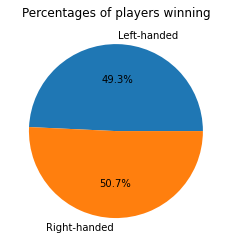

In [37]:
# Use pie chart to show the proportions of left-handed and right-handed players winning
labels='Left-handed', 'Right-handed'
sizes=[diff_left_win, diff_right_win]

plt.pie(sizes, labels=labels, autopct='%1.1f%%')
plt.title('Percentages of players winning')
plt.show()

In [38]:
# Calculate the percentages of one-handed backhand and two-handed backhand players 
# winning in an opposite backhand matches
diff_one_win = 0
diff_two_win = 0

for i in range(len(match1)):
    if match1.iloc[i].winner_backhand != match1.iloc[i].loser_backhand:
        if match1.iloc[i].winner_backhand == 'One-Handed Backhand':
            diff_one_win += 1
        elif match1.iloc[i].winner_backhand == 'Two-Handed Backhand':
            diff_two_win += 1

print('Total number of match with players of different backhand', diff_right_win+diff_left_win)
print('One-handed backhand:', diff_one_win)
print('Two-handed backhand:', diff_two_win)

Total number of match with players of different backhand 2178
One-handed backhand: 1969
Two-handed backhand: 1906


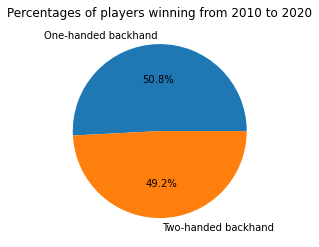

In [39]:
# Use pie chart to show the proportions of one-handed backhand and two-handed backhand players winning
labels='One-handed backhand', 'Two-handed backhand'
sizes=[diff_one_win, diff_two_win]

plt.pie(sizes, labels=labels, autopct='%1.1f%%')
plt.title('Percentages of players winning from 2010 to 2020')
plt.show()

### 2.4 Data derivation - match statistics
Since the match data only contains raw data, e.g. number of aces, number of double faults, number of serve points etc, it would be beneficial for the analysis if these numbers are changed to percentages, e.g. percentage of aces, percentage of double faults, percentage of break points saved etc. In order to do this, 

1. Rearrange the dataframe such that each row contains info and stat of one single player (winner or loser)
1. Compute the percentages of the numbers:
    - 1st_per: percentage of first serve
    - 1st_win_per: percentage of first serve won
    - 2nd_win_per: percentage of second serve won
    - ace_per: percentage of ace
    - sv_win_per: percentage of serve points won
    - df_per: percentage of double faults
    - bp_saved_per: percentage of break points saved
    - pt_win_per: percentage of points won
    - pt_win_per_win: number of points won per minute

In [40]:
# Separate a dataframe for winners
winner = match.iloc[:, np.r_[2:16, 26:36, 45:47]]

# Separate a dataframe for losers
loser = match.iloc[:, np.r_[2:9, 16:23, 26, 36:45, 47:49]]

winner.info()
loser.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23726 entries, 0 to 23725
Data columns (total 26 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   tourney_id          23726 non-null  object 
 1   tourney_name        23726 non-null  object 
 2   surface             23726 non-null  object 
 3   draw_size           23726 non-null  int64  
 4   tourney_level       23726 non-null  object 
 5   tourney_date        23726 non-null  int64  
 6   match_num           23726 non-null  int64  
 7   winner_id           23726 non-null  int64  
 8   winner_seed         23726 non-null  float64
 9   winner_name         23726 non-null  object 
 10  winner_hand         23726 non-null  object 
 11  winner_ht           23726 non-null  float64
 12  winner_ioc          23726 non-null  object 
 13  winner_age          23726 non-null  float64
 14  minutes             23726 non-null  float64
 15  w_ace               23726 non-null  float64
 16  w_df

In [41]:
# For winners
# Create a dataframe for players info
winner_info = winner.iloc[:, np.r_[0:14, 24:26]]

# Create a dictionary to compute the percentages for winners
d_winner = {'tourney_id':winner.tourney_id,
            'match_num': winner.match_num,
            'winner_id': winner.winner_id,
            '1st_per': winner.w_1stIn/winner.w_svpt,
            '1st_win_per': winner.w_1stWon/winner.w_1stIn,
            'ace_per': winner.w_ace /winner.w_svpt,
            '2nd_win_per': winner.w_2ndWon / (winner.w_svpt-winner.w_1stIn), 
            'sv_win_per': (winner.w_1stWon+winner.w_2ndWon)/winner.w_svpt,
            'df_per': winner.w_df/winner.w_svpt,
            'bp_saved_per': winner.w_bpSaved/winner.w_bpFaced,
            'pt_win_per': (winner.w_1stWon+winner.w_2ndWon+(loser.l_svpt-loser.l_1stWon-loser.l_2ndWon))/(winner.w_svpt+loser.l_svpt),
            'pt_win_per_min': (winner.w_1stWon+winner.w_2ndWon+(loser.l_svpt-loser.l_1stWon-loser.l_2ndWon))/winner.minutes,
            'result': 1}

# Construct a new dataframe for stat
winner_stat = pd.DataFrame(data=d_winner)

# Merge the players info and their match stat
winner_final = pd.merge(winner_info, winner_stat, on=['tourney_id','winner_id','match_num'])
winner_final.shape
# Rename columns containing 'winner' to 'player'
winner_final.columns = winner_final.columns.str.replace('winner', 'player')
winner_final.shape

(23726, 26)

In [42]:
# For losers
# Create a dataframe for players info
loser_info = loser.iloc[:, np.r_[0:14, 24:26]]

# Create a dictionary to compute the percentages for losers
d_loser = {'tourney_id':winner.tourney_id,
           'match_num': winner.match_num,
           'loser_id': loser.loser_id,
           '1st_per': loser.l_1stIn/loser.l_svpt,
           '1st_win_per': loser.l_1stWon/loser.l_1stIn,
           'ace_per': loser.l_ace /loser.l_svpt,
           '2nd_win_per': loser.l_2ndWon / (loser.l_svpt-loser.l_1stIn),
           'sv_win_per': (loser.l_1stWon+loser.l_2ndWon)/loser.l_svpt,
           'df_per': loser.l_df/loser.l_svpt,
           'bp_saved_per': loser.l_bpSaved/loser.l_bpFaced,
           'pt_win_per': (loser.l_1stWon+loser.l_2ndWon+(winner.w_svpt-winner.w_1stWon-winner.w_2ndWon))/(loser.l_svpt+winner.w_svpt),
           'pt_win_per_min': (loser.l_1stWon+loser.l_2ndWon+(winner.w_svpt-winner.w_1stWon-winner.w_2ndWon))/loser.minutes,
           'result': 0}

# Construct a new dataframe for stat
loser_stat = pd.DataFrame(data=d_loser)    

# Merge the players info and their match stat
loser_final = loser_info.merge(loser_stat, on=['tourney_id','loser_id','match_num'])

# Rename columns containing 'loser' to 'player'
loser_final.columns = loser_final.columns.str.replace('loser', 'player')
loser_final.shape

(23726, 26)

In [43]:
# Combine the two dataframes
player_stat = winner_final.append(loser_final)

# Drop rows with missing values
player_stat = player_stat.dropna()

player_stat.shape

(44918, 26)

In [44]:
# Add the player's backhand style to the dataframe
player_stat = player_stat.merge(players[['player_id', 'backhand']], on='player_id')

# Replace 'L' and 'R' to 0 and 1 for handedness
player_stat['player_hand'] = player_stat['player_hand'].replace({'L':0, 'R':1})

# Replace 'One-handed backhand' and 'Two-handed backhand' to 1 and 2 
player_stat['backhand'] = player_stat['backhand'].replace({'One-Handed Backhand':1, 'Two-Handed Backhand':2})

In [45]:
player_stat.head()

,tourney_id,tourney_name,surface,draw_size,tourney_level,tourney_date,match_num,player_id,player_seed,player_name,...,1st_win_per,ace_per,2nd_win_per,sv_win_per,df_per,bp_saved_per,pt_win_per,pt_win_per_min,result,backhand
0,2019-M020,Brisbane,Hard,32,A,20181231,300,105453,2.0,Kei Nishikori,...,0.704545,0.038961,0.515152,0.623377,0.038961,0.500000,0.531073,0.758065,1,2
1,2019-M020,Brisbane,Hard,32,A,20181231,298,105453,2.0,Kei Nishikori,...,0.787879,0.042553,0.642857,0.744681,0.042553,1.000000,0.645161,0.909091,1,2
2,2019-M020,Brisbane,Hard,32,A,20181231,294,105453,2.0,Kei Nishikori,...,0.787234,0.084746,0.750000,0.779661,0.033898,0.000000,0.546763,0.760000,1,2
3,2019-580,Australian Open,Hard,128,G,20190114,199,105453,8.0,Kei Nishikori,...,0.769231,0.037500,0.714286,0.750000,0.037500,0.500000,0.577381,0.769841,1,2
4,2019-0407,Rotterdam,Hard,32,A,20190211,297,105453,1.0,Kei Nishikori,...,0.722222,0.053571,0.400000,0.607143,0.000000,0.333333,0.605505,0.846154,1,2


### 2.5 Correlation matrix

Now we have a dataframe containing all the players info and the match statistics. A correlation heatmap using Spearman's correlation is constructed to find out the relationships between variables.


Then the heatmap is restricted to the correlations with player rank.

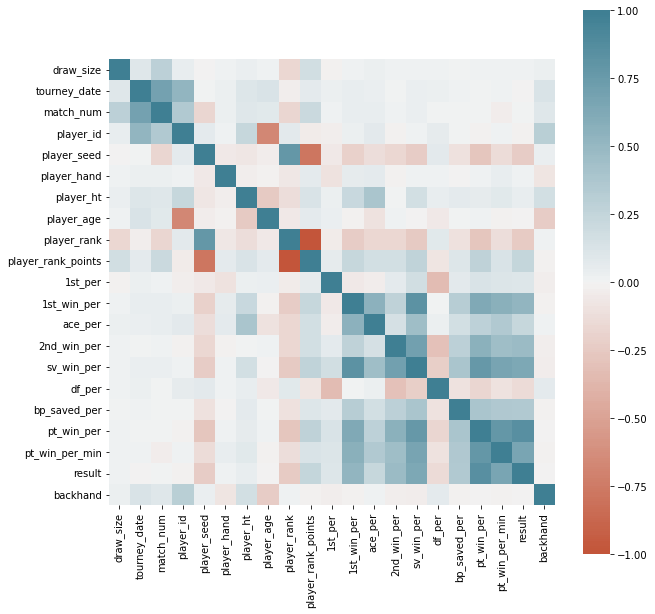

In [46]:
# Correlation heatmap
corr = player_stat.corr(method='spearman')
plt.figure(figsize=(10, 10))

ax = sns.heatmap(corr, vmin=-1, vmax=1, center=0, cmap=sns.diverging_palette(20, 220, n=200), square=True)

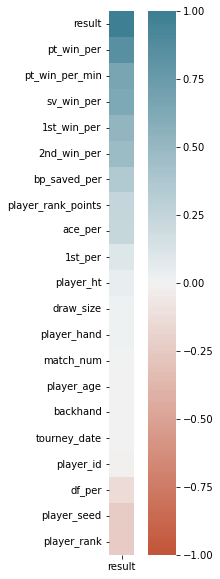

In [47]:
# Restrict the heatmap to correlations with result
corr_result = corr[['result']]

# Sort by correlation
corr_result = corr_result.sort_values(by='result', ascending=False)

plt.figure(figsize=(5, 10))
ax = sns.heatmap(corr_result, vmin=-1, vmax=1, center=0, cmap=sns.diverging_palette(20, 220, n=200), square=True)

In [48]:
# Code adopoted from Lab Feedback 04
# Find out the variables that are most correlated with 'result'

# Make a copy of the correlation matrix
corr1 = corr.copy()

# Reset the index such that the variables names are stored as a new column
corr1.index.name = 'var1'
corr1.reset_index(inplace=True)

# Melt the table and preserve only the variable column
corr_pair = corr1.melt(id_vars=['var1'])

# Rename the names of columns
corr_pair = corr_pair.rename(columns={'variable':'var2', 'value':'corr'})

# Remove rows where var1 and va2 are the same
corr_pair = corr_pair.drop(corr_pair[corr_pair['var1'] == corr_pair['var2']].index)

# Sort the rows on correlation
corr_pair = corr_pair.sort_values(by='corr', ascending=False)

# Add a column wiht absolute correlation
corr_pair['abs_corr'] = abs(corr_pair['corr'])

# Sort on absolute correlation
corr_pair = corr_pair.sort_values(by='abs_corr', ascending=False)

# Print the most correlated variables with 'result'
print('Top ten most correlated variables with match result')
print(corr_pair[corr_pair.var1 == 'result'].head(10))

Top ten most correlated variables with match result
       var1                var2      corr  abs_corr
376  result          pt_win_per  0.850225  0.850225
397  result      pt_win_per_min  0.662998  0.662998
313  result          sv_win_per  0.646538  0.646538
250  result         1st_win_per  0.518252  0.518252
292  result         2nd_win_per  0.471276  0.471276
355  result        bp_saved_per  0.354970  0.354970
208  result  player_rank_points  0.249039  0.249039
187  result         player_rank -0.248464  0.248464
103  result         player_seed -0.239798  0.239798
271  result             ace_per  0.231509  0.231509


### 2.6 Data derivation of average match statistics for individual players

Let's summarize the statistics of each player by calculating the average in the last 10 years. 

In [49]:
# Group the data by player, and calculate the mean of stats
player_stat_by_player = player_stat.groupby('player_name').mean()

The percentage of time players spend on different surfaces may also be an interesting factor. The related numbers (percentage of match on each surface and percentage of matches won on each surface) are also calculated.

In [50]:
# Create a new dataframe with players' names
player_surface_stat = pd.DataFrame(data=player_stat.player_name.unique(), columns={'player_name'})

# Initiate empty lists
hard_per =[]
grass_per=[]
clay_per=[]
hard_win_per =[]
grass_win_per=[]
clay_win_per=[]

# For each player, calculate the percentage of hard, grass and clay court matches
# Add the percentages to the lists
for name in player_stat.player_name.unique():
    hard_per.append(player_stat.loc[(player_stat['player_name']==name)&(player_stat['surface']=='Hard')].surface.count()/player_stat.loc[player_stat['player_name']==name].surface.count())
    grass_per.append(player_stat.loc[(player_stat['player_name']==name)&(player_stat['surface']=='Grass')].surface.count()/player_stat.loc[player_stat['player_name']==name].surface.count())
    clay_per.append(player_stat.loc[(player_stat['player_name']==name)&(player_stat['surface']=='Clay')].surface.count()/player_stat.loc[player_stat['player_name']==name].surface.count())
    hard_win_per.append(player_stat.loc[(player_stat['player_name']==name)&(player_stat['surface']=='Hard')&(player_stat['result']==1)].surface.count()/player_stat.loc[(player_stat['player_name']==name)&(player_stat['surface']=='Hard')].surface.count())
    grass_win_per.append(player_stat.loc[(player_stat['player_name']==name)&(player_stat['surface']=='Grass')&(player_stat['result']==1)].surface.count()/player_stat.loc[(player_stat['player_name']==name)&(player_stat['surface']=='Grass')].surface.count())
    clay_win_per.append(player_stat.loc[(player_stat['player_name']==name)&(player_stat['surface']=='Clay')&(player_stat['result']==1)].surface.count()/player_stat.loc[(player_stat['player_name']==name)&(player_stat['surface']=='Clay')].surface.count())

# Add the lists to the dataframe
player_surface_stat['hard_per']=hard_per
player_surface_stat['grass_per']=grass_per
player_surface_stat['clay_per']=clay_per
player_surface_stat['hard_win_per']=hard_win_per
player_surface_stat['grass_win_per']=grass_win_per
player_surface_stat['clay_win_per']=clay_win_per

/var/folders/mk/x97yxl6121bfr4x7_4d7xfyc0000gn/T/ipykernel_38239/3861643169.py:19: RuntimeWarning: invalid value encountered in long_scalars
  grass_win_per.append(player_stat.loc[(player_stat['player_name']==name)&(player_stat['surface']=='Grass')&(player_stat['result']==1)].surface.count()/player_stat.loc[(player_stat['player_name']==name)&(player_stat['surface']=='Grass')].surface.count())
/var/folders/mk/x97yxl6121bfr4x7_4d7xfyc0000gn/T/ipykernel_38239/3861643169.py:18: RuntimeWarning: invalid value encountered in long_scalars
  hard_win_per.append(player_stat.loc[(player_stat['player_name']==name)&(player_stat['surface']=='Hard')&(player_stat['result']==1)].surface.count()/player_stat.loc[(player_stat['player_name']==name)&(player_stat['surface']=='Hard')].surface.count())
/var/folders/mk/x97yxl6121bfr4x7_4d7xfyc0000gn/T/ipykernel_38239/3861643169.py:20: RuntimeWarning: invalid value encountered in long_scalars
  clay_win_per.append(player_stat.loc[(player_stat['player_name']==nam

In [51]:
# Merge the different court surface percentages with the player_stat_by_player dataframe
player_stat_by_player = player_stat_by_player.reset_index()
player_stat_by_player = player_stat_by_player.merge(player_surface_stat, on='player_name')

Try to find out an overview of top-ranked players.

In [52]:
# Sort by player rank to look at the top-ranked players' stats
player_stat_by_player = player_stat_by_player.sort_values(by=['player_rank'])
player_stat_by_player

,player_name,draw_size,tourney_date,match_num,player_id,player_seed,player_hand,player_ht,player_age,player_rank,...,pt_win_per,pt_win_per_min,result,backhand,hard_per,grass_per,clay_per,hard_win_per,grass_win_per,clay_win_per
197,Novak Djokovic,76.075862,2.014660e+07,169.839655,104925.0,3.153448,1.0,188.0,27.660502,2.479310,...,0.555378,0.777507,0.855172,2.0,0.648276,0.091379,0.260345,0.856383,0.849057,0.854305
214,Rafael Nadal,75.189687,2.014550e+07,167.882136,104745.0,3.143646,0.0,185.0,28.470315,2.657459,...,0.553569,0.705302,0.830571,2.0,0.506446,0.069982,0.423573,0.781818,0.789474,0.895652
233,Roger Federer,74.046316,2.014097e+07,143.450526,103819.0,2.936842,1.0,185.0,32.874343,3.189474,...,0.546675,0.863779,0.804211,1.0,0.656842,0.157895,0.185263,0.814103,0.853333,0.727273
232,Robin Soderling,64.752475,2.010422e+07,48.188119,104417.0,5.267327,1.0,193.0,26.154011,5.594059,...,0.529368,0.788607,0.702970,2.0,0.584158,0.049505,0.366337,0.711864,0.600000,0.702703
270,Tomas Berdych,66.169772,2.013674e+07,116.954451,104607.0,7.716356,1.0,196.0,28.309774,11.515528,...,0.523914,0.741380,0.652174,2.0,0.681159,0.095238,0.223602,0.656535,0.630435,0.648148
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45,Daniel Windahl,4.000000,2.016030e+07,3.500000,125803.0,33.000000,1.0,188.0,19.611225,930.000000,...,0.388792,0.639805,0.000000,2.0,1.000000,0.000000,0.000000,0.000000,NaN,NaN
60,Dominic Inglot,32.000000,2.013092e+07,1.000000,104693.0,33.000000,1.0,196.0,27.531828,941.000000,...,0.458333,0.808824,0.000000,1.0,1.000000,0.000000,0.000000,0.000000,NaN,NaN
167,Martin Emmrich,32.000000,2.010061e+07,9.000000,104465.0,33.000000,0.0,183.0,25.489391,994.000000,...,0.371134,0.553846,0.000000,2.0,0.000000,1.000000,0.000000,NaN,0.000000,NaN
267,Thomas Muster,28.000000,2.010759e+07,7.000000,101404.0,33.000000,0.0,180.0,43.651380,1020.000000,...,0.419536,0.689527,0.000000,1.0,0.666667,0.000000,0.333333,0.000000,NaN,0.000000


Some interesting observations:
- The total points won by the top-ranked players are about 55 %, which is surprisingly low, considering that two similar-level players should each get 50 % of the points.

- Federer's percentage of points won per minutes is higher than Nadal and Djokovic. This is actually one of his strategies - keeping his game short when he is winning. 

- Nadal, the king of clay, spends significantly more time on clay court than Djokovic and Federer. He has also won much more on clay than on hard or grass courts.

- Federer spends much more time on grass courts than Djokovic and Nadal. He also performs the best on grass court among the three.

- Djokovic does not have a favourable surface, he performs equally well on all surfaces.

- The total points won by the GOATs are about 55 %, which is surprisingly low, considering that two similar-level players should each get 50 % of the points.



Finally, let us use scatter plots to visualise the relationships between the ten correlated variables with match result for all players.

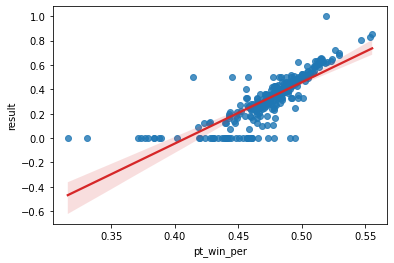

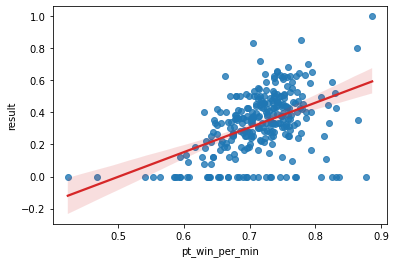

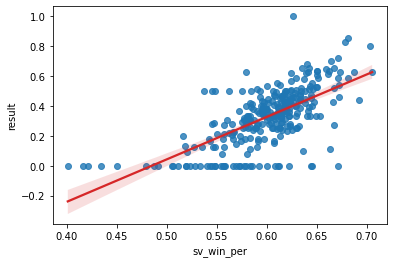

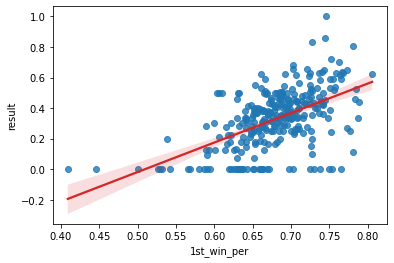

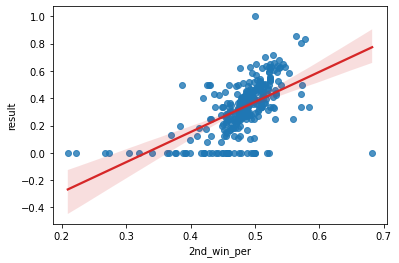

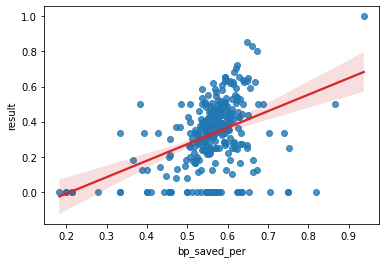

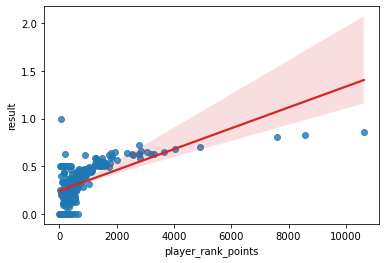

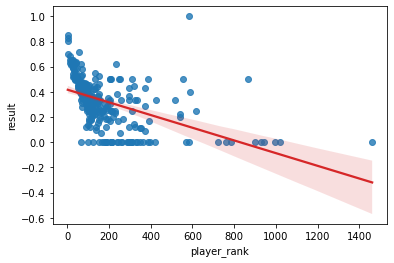

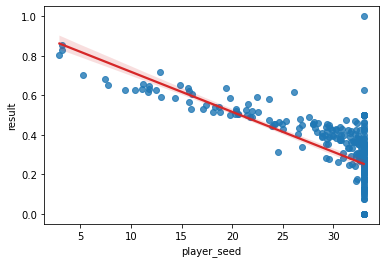

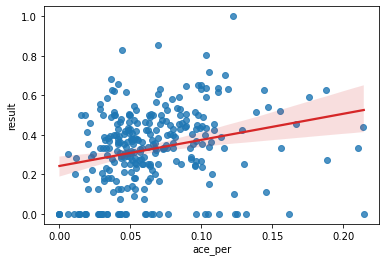

In [53]:
# Plot scatterplots for top 10 correlated variable with match result
for i in corr_pair[corr_pair.var1 == 'result'].head(10)['var2'].tolist():
    sns.regplot(data=player_stat_by_player, x=i, y='result', 
            scatter_kws={'color':'tab:blue'}, line_kws={'color':'tab:red'})
    plt.show()

### 2.7 Do taller players serve better? (with more ace points and less double faults)

<AxesSubplot:title={'center':'Ace percentage versus players height'}, xlabel='player_ht', ylabel='ace_per'>

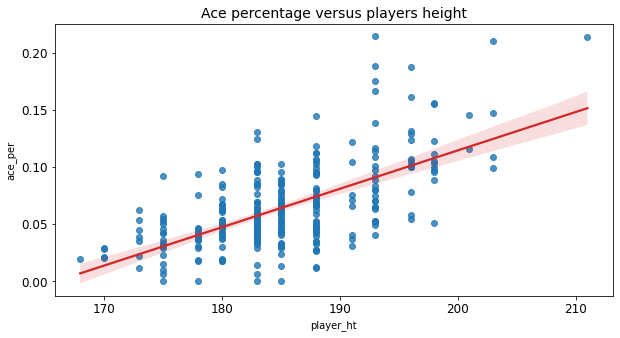

In [54]:
# Scatter plot and regression line to show relatinoship between player's height and ace points
plt.figure(figsize=(10, 5))
plt.xticks(size=12)
plt.yticks(size=12)
plt.title('Ace percentage versus players height', fontsize=14)
sns.regplot(data=player_stat_by_player, x='player_ht', y='ace_per', scatter_kws={'color':'tab:blue'}, line_kws={'color':'tab:red'})

<AxesSubplot:title={'center':'Double fault percentage versus players height'}, xlabel='player_ht', ylabel='df_per'>

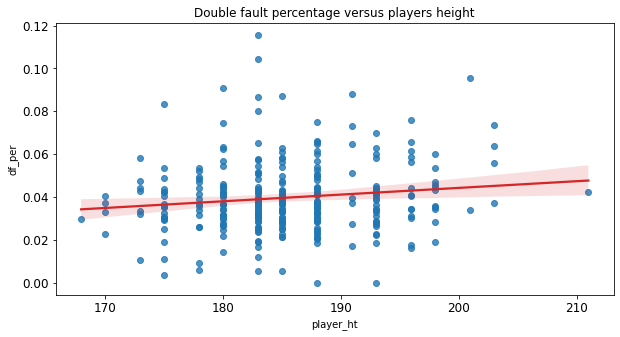

In [55]:
# Scatter plot and regression line to show relatinoship between player's height and double faults percentage
plt.figure(figsize=(10, 5))
plt.xticks(size=12)
plt.yticks(size=12)
plt.title('Double fault percentage versus players height', fontsize=12)
sns.regplot(data=player_stat_by_player, x='player_ht', y='df_per', scatter_kws={'color':'tab:blue'}, line_kws={'color':'tab:red'})

### 2.8 k-Means Clustering

Using k-means clustering, players are categorised into clusters only by their match stats. After that, compare the ranks between clusters to find out whether certain strategies in playing tennis help players achieve higher ranks.

In [56]:
# Import library for k-means
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

In [57]:
# Code adapted from https://realpython.com/k-means-clustering-python/#how-to-perform-k-means-clustering-in-python
# Make a copy of player_stat_by_player
player_stat_by_player_kmeans = player_stat_by_player.copy()
player_stat_by_player_kmeans.info()

# Delete unrelated columns
player_stat_by_player_kmeans = player_stat_by_player_kmeans.iloc[:, np.r_[11:18]]
player_stat_by_player_kmeans.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 291 entries, 197 to 55
Data columns (total 28 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   player_name         291 non-null    object 
 1   draw_size           291 non-null    float64
 2   tourney_date        291 non-null    float64
 3   match_num           291 non-null    float64
 4   player_id           291 non-null    float64
 5   player_seed         291 non-null    float64
 6   player_hand         291 non-null    float64
 7   player_ht           291 non-null    float64
 8   player_age          291 non-null    float64
 9   player_rank         291 non-null    float64
 10  player_rank_points  291 non-null    float64
 11  1st_per             291 non-null    float64
 12  1st_win_per         291 non-null    float64
 13  ace_per             291 non-null    float64
 14  2nd_win_per         291 non-null    float64
 15  sv_win_per          291 non-null    float64
 16  df_per 

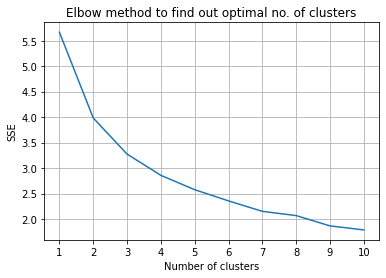

In [58]:
# Use elbow method to determine the best number of clusters

# kwargs for kmeans
kmeans_kwargs = {'init': 'random','n_init': 10,}

# List to hold the SSE values for each k
sse = []
for k in range(1, 11):
    kmeans=KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans.fit(player_stat_by_player_kmeans)
    sse.append(kmeans.inertia_)

# Plot SSE versus number of clusters
plt.plot(range(1, 11), sse)
plt.xticks(range(1, 11))
plt.xlabel('Number of clusters')
plt.ylabel('SSE')
plt.grid(visible=True)
plt.title('Elbow method to find out optimal no. of clusters')
plt.show()

In [59]:
# Since the elbow is not easily identified in the plot, a python package, kneed, can be used to
# identify the elbow point
from kneed import KneeLocator
kl = KneeLocator(range(1, 11), sse, curve='convex', direction='decreasing')
kl.elbow

3

In [60]:
# KMeans with 3 clusters
kmeans = KMeans(init='random', n_clusters=3, n_init=10)
kmeans.fit_predict(player_stat_by_player_kmeans)
label = kmeans.labels_
label

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0,
       1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1,
       1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1,
       1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1,
       1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 2, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 2, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 2, 0, 0, 1, 2, 0, 0, 0, 0, 1, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 2, 0,
       2, 1, 2, 1, 2, 0, 0, 0, 0, 0, 1, 0, 2, 1, 2, 0, 1, 2, 0, 2, 2, 2,
       0, 2, 0, 1, 0, 2, 0, 0, 0, 1, 1, 2, 0, 1, 0, 0, 2, 2, 0, 1, 2, 2,
       1, 0, 1, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 2, 0, 1, 2,
       2, 1, 2, 2, 1], dtype=int32)

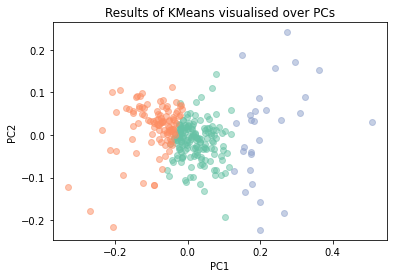

In [61]:
# Visualise the result as a scatter plot

# Fit a PCA to the data
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
pca.fit(player_stat_by_player_kmeans)

# Components of PCA
projectedAxes = pca.transform(player_stat_by_player_kmeans)
projectedAxes = pd.DataFrame(projectedAxes)
projectedAxes

# Plot a scatter plot
plt.figure()
plt.title('Results of KMeans visualised over PCA')
plt.xlabel('PC1')
plt.ylabel('PC2')

plt.scatter(projectedAxes[label==0][0], projectedAxes[label==0][1], alpha=0.5, c = "#66c2a5")
plt.scatter(projectedAxes[label==1][0], projectedAxes[label==1][1], alpha=0.5, c = "#fc8d62")
plt.scatter(projectedAxes[label==2][0], projectedAxes[label==2][1], alpha=0.5, c = "#8da0cb")
plt.scatter(projectedAxes[label==3][0], projectedAxes[label==3][1], alpha=0.5, c = "#DBDBDB")
plt.scatter(projectedAxes[label==4][0], projectedAxes[label==4][1], alpha=0.5, c = "black")
plt.show()

In [62]:
print(pca.explained_variance_)
print(pca.explained_variance_ratio_)

loadings=pd.DataFrame(pca.components_,columns=player_stat_by_player_kmeans.columns.values)
loadings=loadings.transpose()
loadings=loadings.abs()
loadings=loadings.sort_values(by =0,ascending=False)
print(loadings)

[0.01063394 0.00376506]
[0.54436034 0.19273648]
                     0         1
bp_saved_per  0.770829  0.564053
1st_win_per   0.360557  0.620775
sv_win_per    0.359944  0.373457
2nd_win_per   0.323173  0.090882
ace_per       0.182849  0.343654
1st_per       0.080529  0.168170
df_per        0.043613  0.048716


In [63]:
# Add the cluster label into players stat
player_stat_label = player_stat_by_player.copy()
player_stat_label['cluster_label'] = label.tolist()
player_stat_label.head(10)

,player_name,draw_size,tourney_date,match_num,player_id,player_seed,player_hand,player_ht,player_age,player_rank,...,pt_win_per_min,result,backhand,hard_per,grass_per,clay_per,hard_win_per,grass_win_per,clay_win_per,cluster_label
197,Novak Djokovic,76.075862,2.014660e+07,169.839655,104925.0,3.153448,1.0,188.0,27.660502,2.479310,...,0.777507,0.855172,2.0,0.648276,0.091379,0.260345,0.856383,0.849057,0.854305,1
214,Rafael Nadal,75.189687,2.014550e+07,167.882136,104745.0,3.143646,0.0,185.0,28.470315,2.657459,...,0.705302,0.830571,2.0,0.506446,0.069982,0.423573,0.781818,0.789474,0.895652,1
233,Roger Federer,74.046316,2.014097e+07,143.450526,103819.0,2.936842,1.0,185.0,32.874343,3.189474,...,0.863779,0.804211,1.0,0.656842,0.157895,0.185263,0.814103,0.853333,0.727273,1
232,Robin Soderling,64.752475,2.010422e+07,48.188119,104417.0,5.267327,1.0,193.0,26.154011,5.594059,...,0.788607,0.702970,2.0,0.584158,0.049505,0.366337,0.711864,0.600000,0.702703,1
270,Tomas Berdych,66.169772,2.013674e+07,116.954451,104607.0,7.716356,1.0,196.0,28.309774,11.515528,...,0.741380,0.652174,2.0,0.681159,0.095238,0.223602,0.656535,0.630435,0.648148,1
48,David Ferrer,61.376673,2.013476e+07,99.567878,103970.0,7.407266,1.0,175.0,31.587040,14.288719,...,0.758663,0.682600,2.0,0.523901,0.065010,0.411090,0.649635,0.588235,0.739535,1
18,Andy Roddick,65.983471,2.010915e+07,55.289256,104053.0,9.429752,1.0,188.0,28.601875,14.471074,...,0.736314,0.628099,2.0,0.785124,0.148760,0.066116,0.663158,0.666667,0.125000,1
164,Marin Cilic,62.517895,2.014645e+07,138.738947,105227.0,11.724211,1.0,198.0,26.294653,16.084211,...,0.737460,0.614737,2.0,0.618947,0.111579,0.269474,0.602041,0.716981,0.601562,1
251,Stan Wawrinka,66.528217,2.014521e+07,144.498871,104527.0,11.778781,1.0,183.0,29.641703,20.178330,...,0.774911,0.647856,1.0,0.609481,0.056433,0.334086,0.651852,0.360000,0.689189,1
122,Jo-Wilfried Tsonga,65.925926,2.013915e+07,121.429630,104542.0,10.375309,1.0,188.0,29.009983,21.548148,...,0.761989,0.629630,2.0,0.659259,0.111111,0.229630,0.632959,0.644444,0.612903,1


In [64]:
# Calculate the mean of player stat for each cluster
player_stat_label_grouped = player_stat_label.groupby(by=[player_stat_label.cluster_label]).mean()
player_stat_label_grouped

,draw_size,tourney_date,match_num,player_id,player_seed,player_hand,player_ht,player_age,player_rank,player_rank_points,...,pt_win_per,pt_win_per_min,result,backhand,hard_per,grass_per,clay_per,hard_win_per,grass_win_per,clay_win_per
cluster_label,,,,,,,,,,,,,,,,,,,,,
0,51.345076,2.014023e+07,104.459054,105879.547170,31.336271,0.861635,183.276730,27.336377,166.399932,531.768735,...,0.470622,0.703037,0.297687,1.811321,0.519343,0.100053,0.379322,0.257354,0.223247,0.311130
1,56.467353,2.014364e+07,125.045146,106852.163462,25.144685,0.903846,188.721154,26.850794,137.528892,1338.824790,...,0.494243,0.752514,0.447107,1.730769,0.614038,0.127457,0.258505,0.441948,0.444683,0.426357
2,43.195857,2.012143e+07,38.675885,106077.750000,33.000000,0.821429,184.321429,26.479709,383.983237,176.661066,...,0.419950,0.637555,0.065438,1.785714,0.493932,0.160900,0.345169,0.049206,0.104167,0.051637


Cluster 0 represents players with highest ranks and ranking points. They also have the highest average height. They spend the most time on hard courts yet their average winning percentages across all three court surfaces are similar.

Cluster 1 represents low-ranked players. They are the youngest group of players. They spend more time on grass courts than the other two clusters, and their performance on grass courts is better than in hard and clay courts.

Cluster 2 represents middle-ranked players. They are the oldeste among all three clusters. They have the highest percentage of first serve, meaning they are less agressive server than cluster 0. They also spend the least time on grass court, but their performance on different court surfaces are similar.


### 2.9 What makes the GOATs so great


In [65]:
# For to study the change in performance for GOATs, let us also the data from 2000 to 2020
# Commented out to avoid repeated saved files

# # Code adapted and modified from https://blog.softhints.com/how-to-merge-multiple-csv-files-with-python/
# # Set the working directory
# path1 = '/Users/ceciliali/Documents/MSc Data Science/Principles of Data Science/coursework/atp_matches'

# # Match CSV files by pattern
# all_files = glob.glob(os.path.join(path1, 'atp_*.csv'))

# # Combine all file and export as single CSV file named 'match_data'
# df_from_each_file = (pd.read_csv(f, sep=',') for f in all_files)
# df_match_data = pd.concat(df_from_each_file, ignore_index=True)
# df_match_data.to_csv('goat_data.csv')

In [66]:
# Create new dataframe containing match stats for GOATs
goat = pd.read_csv('goat_data.csv')

# Select rows that contain Federer, Nadal or Djokovic
goat_name=['Novak Djokovic', 'Rafael Nadal', 'Roger Federer']
goat=goat.loc[goat.winner_name.isin(goat_name)|goat.loser_name.isin(goat_name)]

In [67]:
# Select winning rows
# Create a dataframe for winner info
win = goat.iloc[:, np.r_[1:16, 27, 46:48]]

# Create a dictionary to compute the match stats
d_goat = {'tourney_id':goat.tourney_id,
          'match_num': goat.match_num,
          'winner_id': goat.winner_id,
          '1st_per': goat.w_1stIn/goat.w_svpt,
          '1st_win_per': goat.w_1stWon/goat.w_1stIn,
          'ace_per': goat.w_ace /goat.w_svpt,
          '2nd_win_per': goat.w_2ndWon / (goat.w_svpt-goat.w_1stIn), 
          'sv_win_per': (goat.w_1stWon+goat.w_2ndWon)/goat.w_svpt,
          'df_per': goat.w_df/goat.w_svpt,
          'bp_saved_per': goat.w_bpSaved/goat.w_bpFaced,
          'pt_win_per': (goat.w_1stWon+goat.w_2ndWon+(goat.l_svpt-goat.l_1stWon-goat.l_2ndWon))/(goat.w_svpt+goat.l_svpt),
          'pt_win_per_min': (goat.w_1stWon+goat.w_2ndWon+(goat.l_svpt-goat.l_1stWon-goat.l_2ndWon))/goat.minutes,
          'result': 1}

# Construct a new dataframe for stat
goat_win_stat = pd.DataFrame(data=d_goat)

# Merge the players info and their match stat
goat_final = pd.merge(win, goat_win_stat, on=['tourney_id','winner_id','match_num'])

# Rename columns containing 'winner' to 'player'
goat_final.columns = goat_final.columns.str.replace('winner', 'player')
goat_final.shape

(3701, 28)

In [68]:
# Select losing rows
# Create a dataframe for loser info
lose = goat.iloc[:, np.r_[1:8, 16:24, 27, 48:50]]

# Create a dictionary to compute the match stats
d_goat_l = {'tourney_id':goat.tourney_id,
            'match_num': goat.match_num,
            'loser_id': goat.loser_id,
            '1st_per': goat.l_1stIn/goat.l_svpt,
            '1st_win_per': goat.l_1stWon/goat.l_1stIn,
            'ace_per': goat.l_ace /goat.l_svpt,
            '2nd_win_per': goat.l_2ndWon / (goat.l_svpt-goat.l_1stIn), 
            'sv_win_per': (goat.l_1stWon+goat.l_2ndWon)/goat.l_svpt,
            'df_per': goat.l_df/goat.l_svpt,
            'bp_saved_per': goat.l_bpSaved/goat.l_bpFaced,
            'pt_win_per': (goat.l_1stWon+goat.l_2ndWon+(goat.w_svpt-goat.w_1stWon-goat.w_2ndWon))/(goat.l_svpt+goat.w_svpt),
            'pt_win_per_min': (goat.l_1stWon+goat.l_2ndWon+(goat.w_svpt-goat.w_1stWon-goat.w_2ndWon))/goat.minutes,
            'result':0}

# Construct a new dataframe for stat
goat_lose_stat = pd.DataFrame(data=d_goat_l)

# Merge the players info and their match stat
goat_final2 = pd.merge(lose, goat_lose_stat, on=['tourney_id','loser_id','match_num'])

# Rename columns containing 'loser' to 'player'
goat_final2.columns = goat_final.columns.str.replace('loser', 'player')
goat_final2.shape    

(3701, 28)

In [69]:
# Combine winning and losing stat for GOATs
goat_stat = pd.concat([goat_final, goat_final2])

# Select rows that contains GOATs
goat_stat = goat_stat.loc[goat_stat.player_name.isin(goat_name)]

# Delete column 'player_entry'
goat_stat = goat_stat.drop('player_entry', axis=1)

# Delete rows with missing values
goat_stat = goat_stat.dropna()

# Reset index value
goat_stat = goat_stat.reset_index()

goat_stat.shape

(2877, 28)

In [70]:
# Change the date format for tourney_date
goat_stat['tourney_date'] = pd.to_datetime(goat_stat.tourney_date, format='%Y%m%d')

Text(0.5, 1.0, 'GOATs ranks from 2000 to 2020')

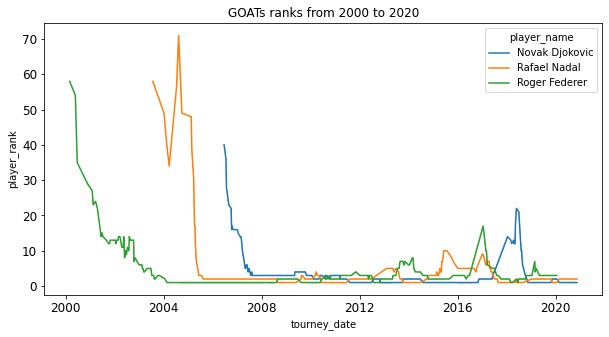

In [71]:
# Use line plots to show GOATs' ranking throughout the years
plt.figure(figsize=(10, 5))
sns.lineplot(data=goat_stat, x='tourney_date', y='player_rank', hue='player_name')
plt.xticks(size=12)
plt.yticks(size=12)
plt.title('GOATs ranks from 2000 to 2020', fontsize=12)

From the year 2008, the GOATs are constantly at the top of the game. They have never fallen out of top 30 since then.

Lastly, the match stats of each player is plotted to observe whethere there is a trend over the years.

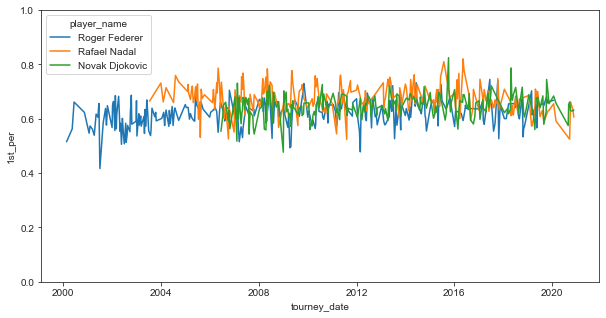

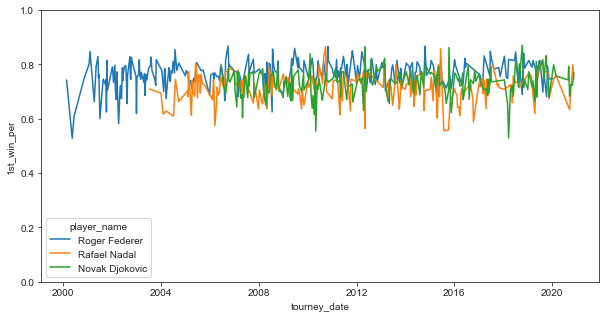

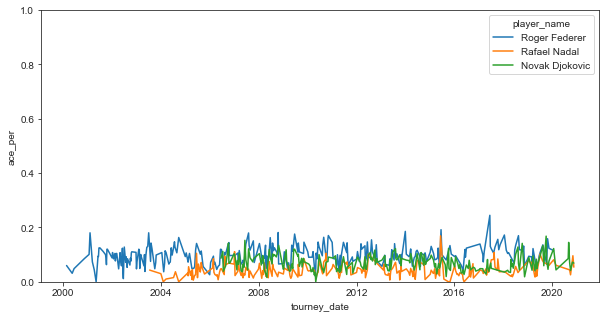

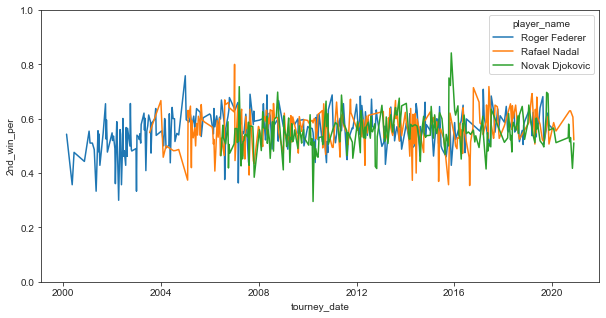

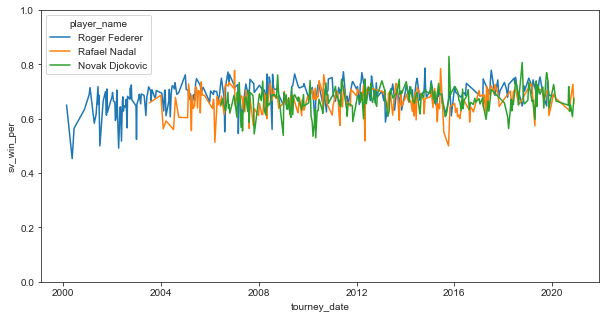

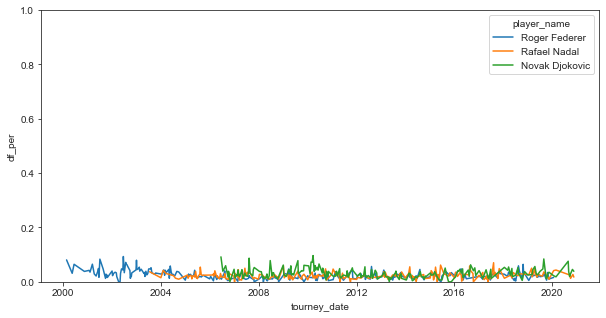

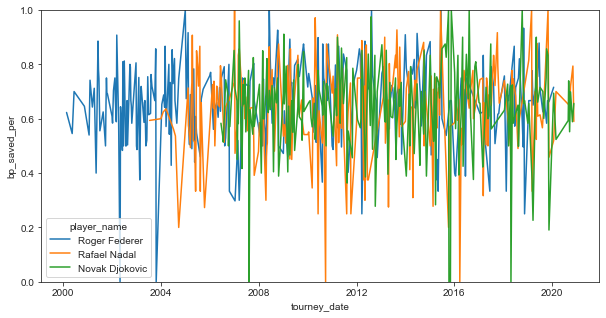

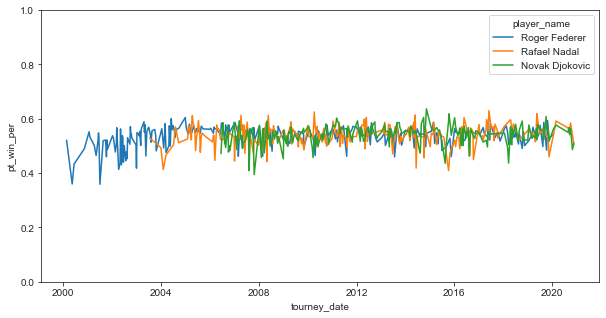

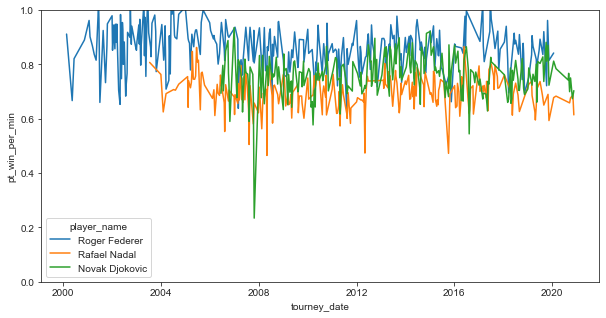

In [72]:
goat_stat_by_date = goat_stat.groupby(['tourney_date', 'player_name']).mean()
goat_stat_by_date = goat_stat_by_date.reset_index()

sns.set_style('ticks')
for i in goat_stat_by_date.iloc[:, 12:21]:
    plt.figure(figsize=(10, 5))
    sns.lineplot(data=goat_stat_by_date, x='tourney_date', y=i, hue='player_name').set(ylim=(0, 1))
    plt.show()

There is no significant trends in the graphs, probably because the graphs are too detailed. Maybe aggregating data to yearly average will help.

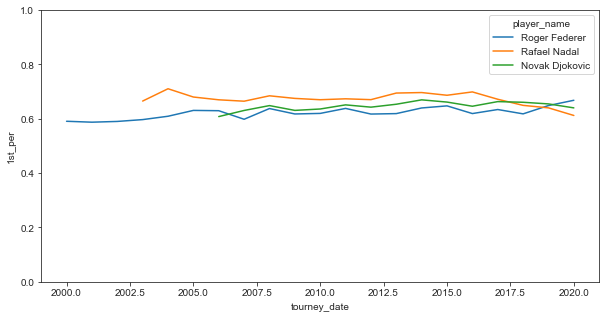

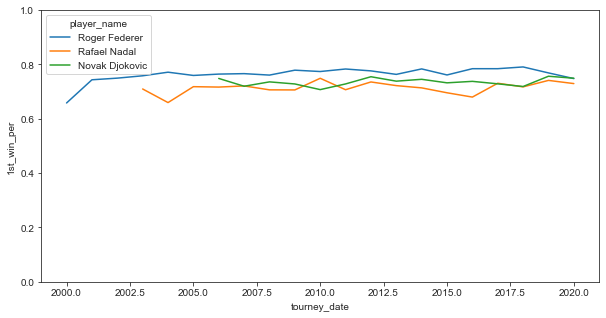

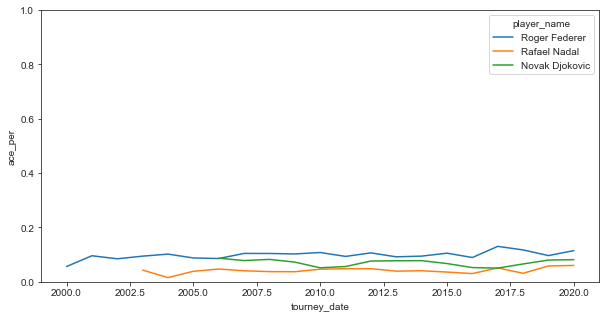

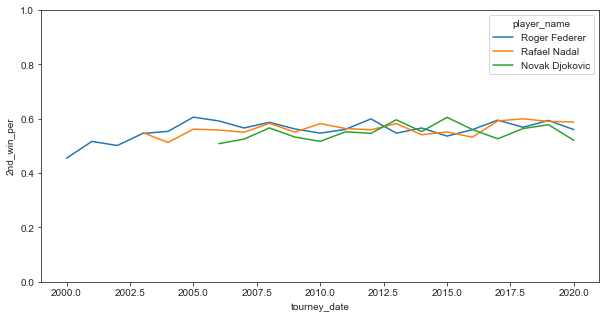

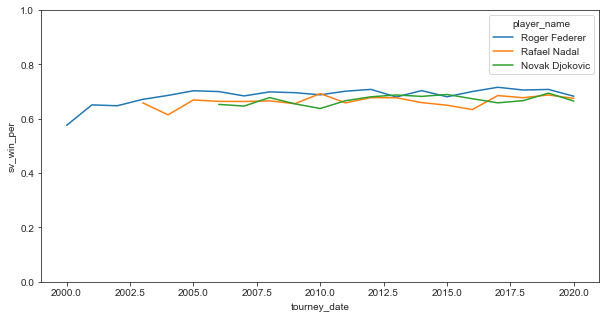

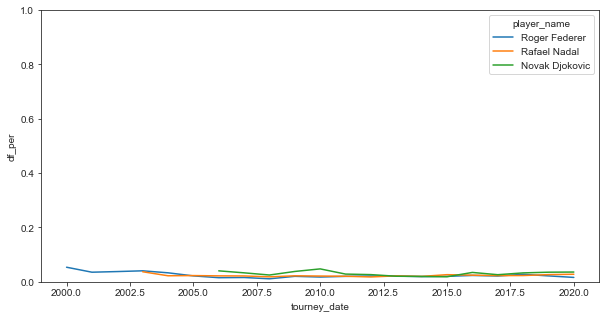

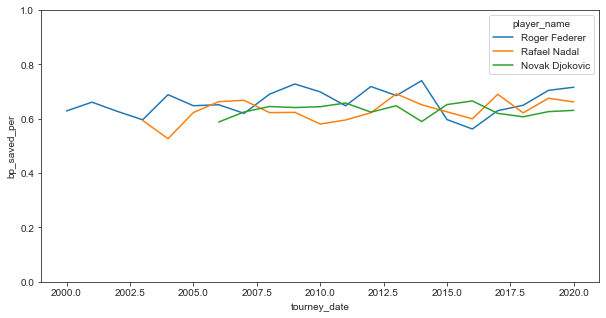

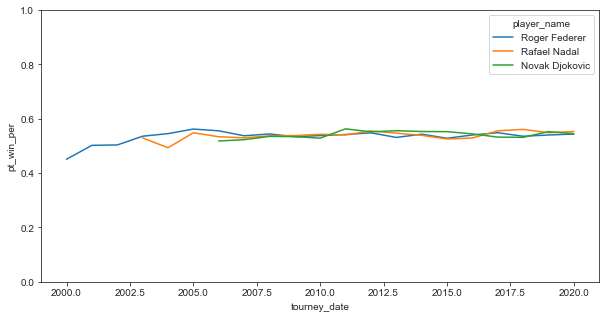

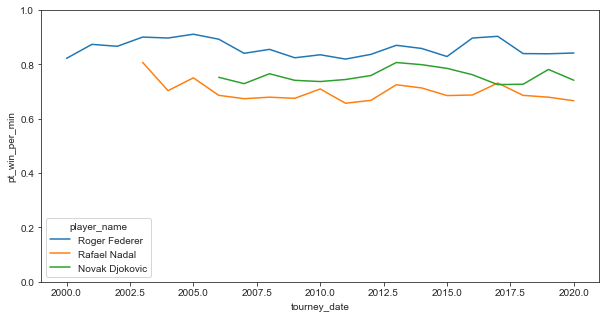

In [73]:
# Aggregating rows in the same year, and calculate the mean for the stats
# Code adapted from https://stackoverflow.com/questions/11391969/how-to-group-pandas-dataframe-entries-by-date-in-a-non-unique-column
goat_stat_by_date = goat_stat_by_date.groupby([goat_stat_by_date['tourney_date'].dt.year, 'player_name']).agg('mean')
goat_stat_by_date = goat_stat_by_date.reset_index()

# Lineplot for each variable
sns.set_style('ticks')
for i in goat_stat_by_date.iloc[:, 12:21]:
    plt.figure(figsize=(10, 5))
    sns.lineplot(data=goat_stat_by_date, x='tourney_date', y=i, hue='player_name').set(ylim=(0, 1))
    plt.show()

Still, there is no obvious trends in the plots. Recall the findings before, that top-ranked players only win 55 % of the points. This implies that a small fluctuation in these stats can result a huge difference in performance. 